# Introduction and setup

Import neccessary libraries.

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

Helper functions.

In [73]:
def parse_datetime(date, time):
    return datetime.strptime(date + ' ' + time, '%d.%m.%Y %H:%M')

def parse_time(time):
    return datetime.strptime(time, '%H:%M').time()

def add_datetime_column(df):
    df['datetime'] = df.apply(lambda x: parse_datetime(x.Date, x.Timestamp), axis=1)
    
def add_time_column(df):
    df['time'] = df.apply(lambda x: parse_time(x.Timestamp), axis=1)

Read in the data. Subject 1 = Behrad, Subject 2 = Gregor, Subject 3 = Kaarel

In [74]:
reaction_subject_1_data, reaction_subject_2_data, reaction_subject_3_data = (
    pd.read_csv('data/reaction_subject_1.csv'),
    pd.read_csv('data/reaction_subject_2.csv'),
    pd.read_csv('data/reaction_subject_3.csv')
)

visual_subject_1_data, visual_subject_2_data, visual_subject_3_data = (
    pd.read_csv('data/visual_subject_1.csv'),
    pd.read_csv('data/visual_subject_2.csv'),
    pd.read_csv('data/visual_subject_3.csv')
)

typing_subject_1_data, typing_subject_2_data, typing_subject_3_data = (
    pd.read_csv('data/typing_subject_1.csv'),
    pd.read_csv('data/typing_subject_2.csv'),
    pd.read_csv('data/typing_subject_3.csv')
)

# Add 'datetime' column to dataframes
add_datetime_column(reaction_subject_1_data)
add_datetime_column(reaction_subject_2_data)
add_datetime_column(reaction_subject_3_data)

# Add 'time' column to dataframes
add_time_column(reaction_subject_1_data)
add_time_column(reaction_subject_2_data)
add_time_column(reaction_subject_3_data)

## Performance throughout the day

First, let's have look at two-hour interval average performance of reaction time test of all the subjects.

In [150]:
# Combine all subjects reaction data into single dataframe
reaction_data = pd.concat([reaction_subject_1_data, reaction_subject_2_data, reaction_subject_3_data])

# Set 'datetime' column as dateframe index for making it possible resample based on it
reaction_data.set_index(reaction_data['datetime'], inplace=True)
reaction_data = reaction_data.loc['2019-11-18':'2019-11-22'] # Disgarding data from 23rd and 24th November since only present for one subject

two_hour_interval_result_means = reaction_data.resample('2H').mean().dropna() # Two-hour interval 'result' means, dropping NaN results
daily_result_means = reaction_data.resample('D').mean() # Daily 'result' means

Plot two-hour frequency averages for each day.

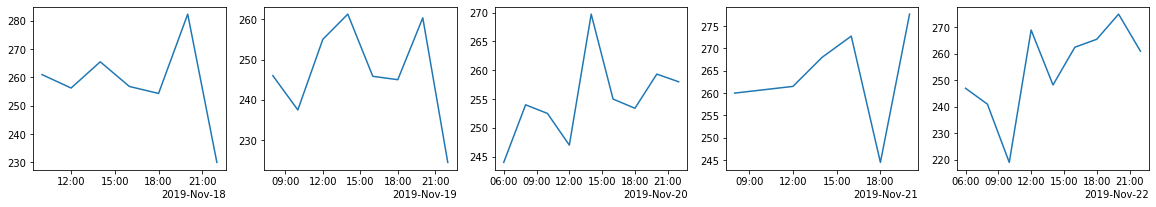

In [156]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, axs = plt.subplots(1, 5, figsize=(20,3))
for day, ax in zip(range(18, 23), axs):
    data = two_hour_interval_result_means.loc['2019-11-' + str(day)]
    ax.plot(data.index, data.result)
    for ax in axs:
        locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
        formatter = mdates.ConciseDateFormatter(locator)
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        
plt.show()